#Tambahkan value aneh, dengan menggunakan .unique
object sama string beda
agent lebih baik diganti menjadi string
stage 1 nggak papa mengubah tipe data
Undefined meal jadi NAN
Reservation status date di cacah jadi tanggal, bulan, tahun
Email : gmail dll
Credit card dicacah coba dicari maknanya
Pemodelan pilih fitur yang korelasi tinggi dengan target (lebih dari 0.7 atau kurang dari 0.7)
Feature selection
anova f test: feature numeric, target categoric
chi square: feature categoric, terget categoric

Kategorik
ordinal ada ranking
nominal setara

Distribusi
Ditentukan, lalu handling

Point statement
Treatment nya

Outlier pakai IQR

Feature transformation

assigned room type apakah available?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import library FP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#Target merupakan cancelation rate (is_canceled)

df = pd.read_csv("hotel_booking.csv") #Load original dataset
pd.set_option("display.max_columns", None)
#copy data for backup
df2 = df.copy()

1. Pengecekan kesesuaian data

In [ ]:
#Mengecek kesesuaian tipe data tiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
#Mengecek kesesuaian tipe data tiap kolom
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Dari hasil di df.info(), terlihat bahwa terdapat beberapa tidak kesesuaian data:
a. Kolom “is_cancelled”, “is_repeated_guest”, ”previous_cancellations”, “previous_bookings_not_canceled” lebih tepat jika tipe datanya boolean
b. Kolom “children”,’’agent”,”company” akan lebih tepat menggunakan tipe data integer
c. Kolom “reservation_status_date” mempunyai data type berupa object, namun lebih tepat bila menggunakan tipe data datetime

In [ ]:
#Mengecek adanya nilai 0 di kolom
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Kolom country, children, agent, dan company memiliki nilai null

Dari hasil command df.describe(), tidak terlihat adanya nilai aneh dari kolom kolom. Semua parameter statistik deskriptif terlihat normal

2. Univariate Analysis untuk melihat distribusi masing masing kolom

Dari kolom kolom yang ada dikelompokan terlebih dahulu, mana kolom yang numerik, dan kategorikal untuk menghindari grafik distribusi yang tidak sesuai 

In [ ]:
#Pengelompokan kolom kolom numerik, dan kategorikal
numeric = ['lead_time','arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month', 'stays_in_weekend_nights','stays_in_week_nights',
           'adults','children','babies','booking_changes', 'days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']

categorical = ['hotel','is_canceled','arrival_date_month','meal','country','market_segment','distribution_channel','is_repeated_guest',
               'previous_cancellations','previous_bookings_not_canceled','reserved_room_type','assigned_room_type','deposit_type','agent','company',
               'customer_type','reservation_status','reservation_status_date','name','email','phone-number','credit_card']

#Setelah melihat dataset kaggle, kami mengambil kesimpulan bahwa agent, dan kompany merupakan sebuah id sehingga dimasukkan dalam tipe kategorikal       

Univariate analysis akan dilakukan pada kolom kolom numerical

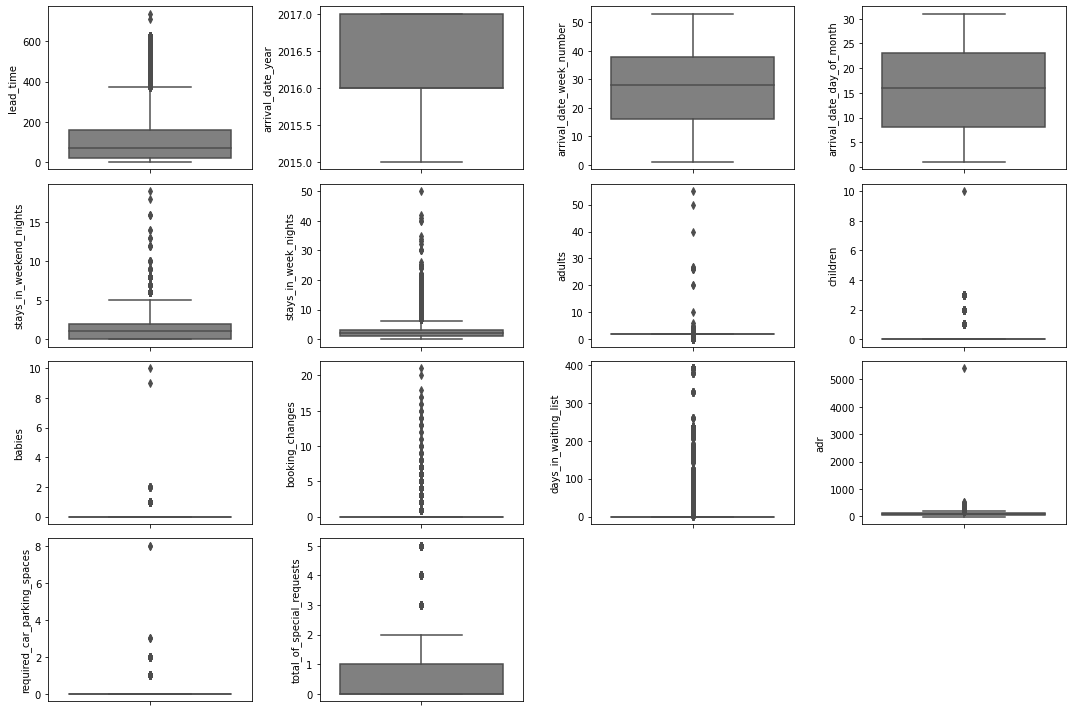

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[numeric[i]], color='gray', orient='v')
    plt.tight_layout()

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

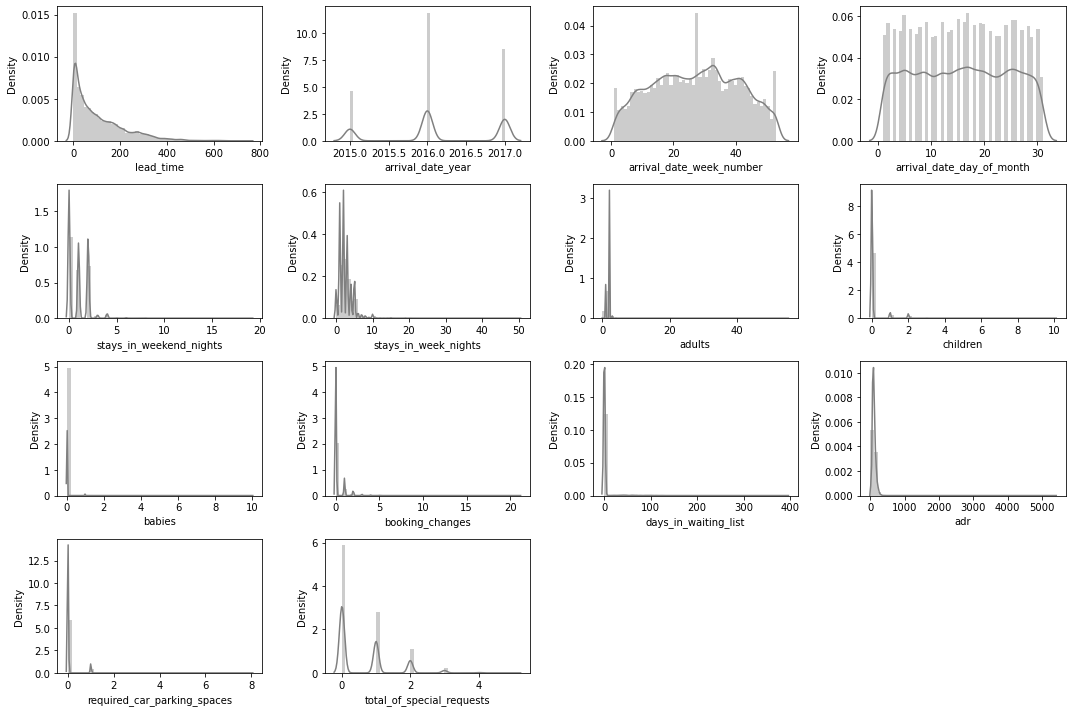

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.distplot(df[numeric[i]], color='gray')
    plt.tight_layout()

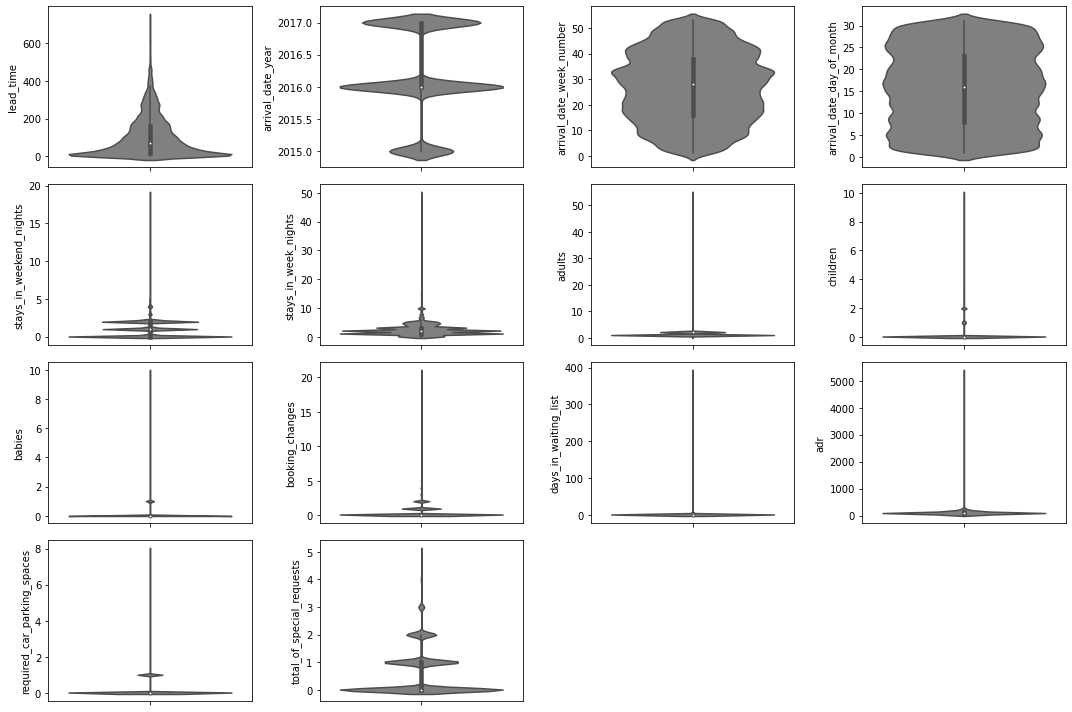

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.violinplot(y=df[numeric[i]], color='gray', orient='v')
    plt.tight_layout()

a.  Kolom “stays_in_week_nights”, “stays_in_weekend_nights”, ”stay_duration”
    mempunyai distribusi positively skewed. (Melihat bentuk box plot, distribution
    plot, dan violin plot). Langkah selanjutnya adalah melakukan menormalkan
    distribusi data, metode yang digunakan bisa menggunakan Log
    transformation, dll. Setelah distribusi data menjadi normal, selanjutnya kita
    lakukan feature scaling bisa berupa Min-max scaler, standard scaler, dan
    robust scaler, dll.
b. Terdapat beberapa kolom yang memiliki outliers, seperti kolom
   “total_of_special_requests”, “required_car_parking_spaces”, “children”,
   “babies”, “adults”. Dari box plot, terdapat beberapa jenis outlier seperti global
   outlier dan collective outlier. Untuk pemodelan, biasanya kita membuang
   global outlier (outlier yang sangat ekstrem), sementara kita membiarkan
   collective outlier tetap ada.
c. Terdapat beberapa nilai yang mendominasi, contohnya nilai 0 pada kolom
   “babies”, 0 pada kolom children, “stay duration” yang mendominasi tidak lebih
   dari 10 hari, dll.

3. Multivariate Analysis

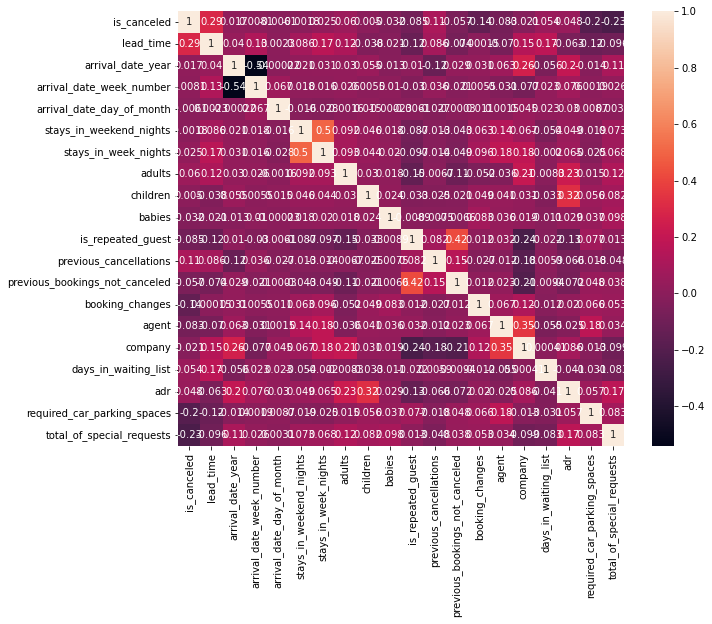

In [ ]:
#Dilakukan correlation untuk tiap2 kolom untuk mencari kolom yang paling tepat untuk dijadikan feature
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

Untuk korelasi antara feature dan label (“is_cancelled”) tidak memiliki korelasi yang kuat. Adapun feature yang bertipe numerik ternyata berupa ID, yaitu “Agent”, ”company”. Kolom tersebut direkomendasikan untuk didrop sementara feature yang lain masih relevan untuk eksplorasi lebih lanjut

Dari correlation heatmap, kita dapat memperoleh korelasi antar feature. Jika korelasi > 0.7 artinya terdapat hubungan 2 feature yang menandakan
multikolinieritas/redundan sehingga salah satu feature harus dibuang. Pada diagram heatmap diperoleh bahwa fitur yang menunjukkan kolom stay berkorelasi > 0.7. Selain itu, feature yang menunjukkan guest juga berkorelasi >0.7

4. Business Insights

Terdapat beberapa insight yang dapat diambil seperti:

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

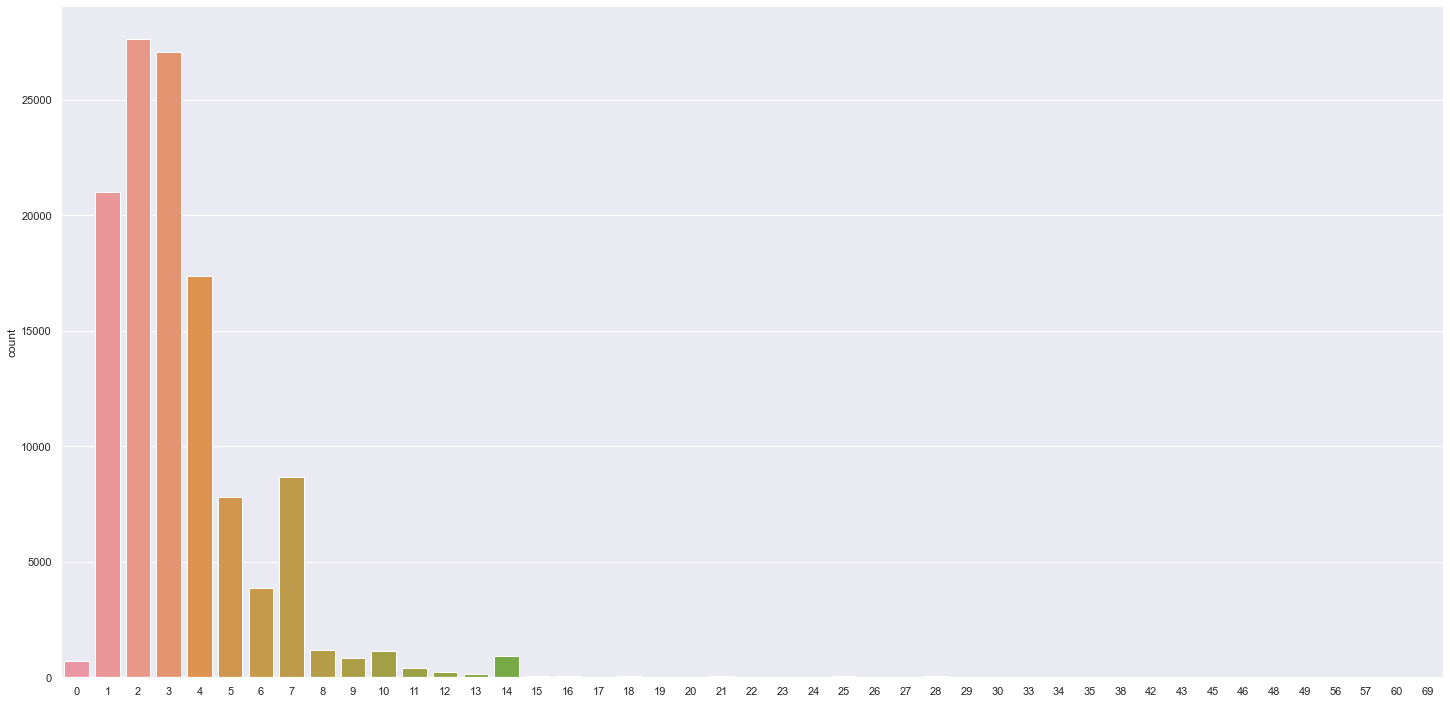

In [ ]:
#Durasi stay pelanggan kurang dari 10 hari
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,10)})
sns.catplot(x= df['stays_in_weekend_nights'] + df['stays_in_week_nights'],
            data=df, 
            kind="count",height = 10, aspect = 2)

Dari hal ini pihak hotel dapat memfokuskan usaha pada pelanggan yang melakukan short stay duration saja. Misal, melakukan promo tambahan
breakfast dan lunch pada pelanggan yang hanya stay selama 2 hari dengan tambahan biaya, sehingga dapat memaksimalkan profit.

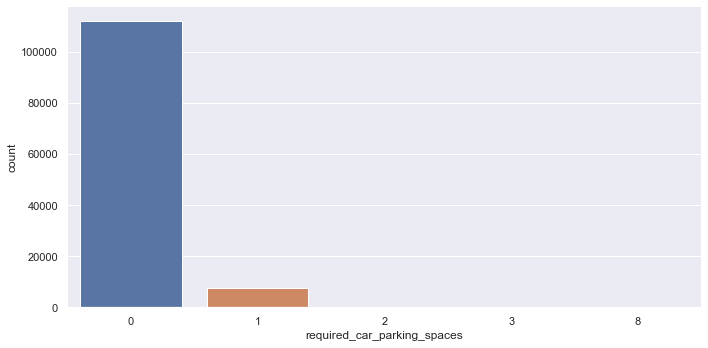

In [ ]:
#Pelanggan tidak banyak menggunakan mobil untuk stay
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,10)})
sns.catplot(x='required_car_parking_spaces', 
            data=df, 
            kind="count",height = 5, aspect = 2)

Hal ini dapat menjadi peluang bisnis bagi pihak hotel untuk menyediakan moda transportasi untuk pelanggan hotel yang ingin berwisata, maupun pergi
menuju ke airport, atau bandara (Bisa menyediakan jasa sewa sopir)

Stage 2 Preprocessing

1. Data Cleansing

In [ ]:
## Handling missing values
# Nilai null di column 'children' mungkin keluarga tidak mempunyai anak
df['children'] = df['children'].fillna(0)
# Dari kaggle dataset column 'agent', dan 'company' merupakan sebuah id. 
#Sehingga null value, kemungkinan memiliki arti bahwa pengunjung tidak memesan melalui 'agent' dan 'company' sehingga dimasukkan 0 
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)
# Dari kaggle dataset column 'country' merupakan singkatan nama negara.
# Maka null kemungkinan berarti tidak punya negara maka null akan di isi 'NON' yang berarti tidak punya kewarganegaraan
df['country'] = df['country'].fillna('NON')

In [ ]:
# Mengecek nilai null kembali
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [ ]:
#Mengecek data duplikat
print('Baris dengan data duplikat:', df.duplicated().sum())

Baris dengan data duplikat: 0


In [ ]:
#Memperbaiki tipe data
df['children'] = df['children'].astype('int64')
df['agent'] = df['agent'].astype('int64')
df['company'] = df['company'].astype('int64')
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

In [ ]:
#Mengecek nilai aneh di kolom meal
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [ ]:
# Mengganti Undefined meal sebagai missing Values NAN
df['meal'] = df['meal'].replace(['Undefined'], 'NAN')
df['meal'].value_counts()

BB     92310
HB     14463
SC     10650
NAN     1169
FB       798
Name: meal, dtype: int64

In [ ]:
#Handle outlier
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')
filtered_entries = np.array([True] * len(df))

for col in numeric:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 119390
Jumlah baris setelah memfilter outlier: 98480


In [ ]:
# Menghilangkan data yang bernilai 0 guest, dan 0 malam
# Melakukan feature ekstrasi berupa, pembuatan kolom baru total guest, dan stay duration
df['total_guests'] = df['adults'] + df['children'] + df['babies']
print('Data with 0 guest: {0} out of {1} all data'.format(df[df['total_guests'] == 0].shape[0], df.shape[0]))
df['stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
print('Data with 0 night: {0} out of {1} all data'.format(df[df['stay_duration'] == 0].shape[0], df.shape[0]))
# Pembuatan df baru untuk data yang telah dipre process
df_clean = df[(df['total_guests'] > 0) & (df['stay_duration'] > 0)].copy()

print('before pre-processing:', df.shape[0])
print('after pre-processing:', df_clean.shape[0])

Data with 0 guest: 0 out of 98480 all data
Data with 0 night: 590 out of 98480 all data
before pre-processing: 98480
after pre-processing: 97890


C:\Users\LENOVO\AppData\Local\Temp/ipykernel_19120/517926717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_guests'] = df['adults'] + df['children'] + df['babies']
C:\Users\LENOVO\AppData\Local\Temp/ipykernel_19120/517926717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


In [ ]:
#Mengedrop kolom tdk berguna di dataset
df_clean = df_clean.drop(columns = ['adults','children','babies','stays_in_weekend_nights','stays_in_week_nights'])

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97890 entries, 2 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           97890 non-null  object        
 1   is_canceled                     97890 non-null  int64         
 2   lead_time                       97890 non-null  int64         
 3   arrival_date_year               97890 non-null  int64         
 4   arrival_date_month              97890 non-null  object        
 5   arrival_date_week_number        97890 non-null  int64         
 6   arrival_date_day_of_month       97890 non-null  int64         
 7   meal                            97890 non-null  object        
 8   country                         97890 non-null  object        
 9   market_segment                  97890 non-null  object        
 10  distribution_channel            97890 non-null  object        
 11  i

In [ ]:
#Menyimpan ke csv file baru
df_clean.to_csv('Data_Hotel_Cleaning.csv', index=False)

#df_baru

In [ ]:
#Meload df baru
df_baru = pd.read_csv("/content/drive/MyDrive/Data Science python/RAKAMIN/Data_Hotel_Cleaning.csv")

In [ ]:
#Pembuatan backup df
df_backup = df_baru.copy()

In [ ]:
pd.set_option("display.max_columns", None)
df_backup.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,total_guests,stay_duration
0,Resort Hotel,0,7,2015,July,27,1,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734,1,1
1,Resort Hotel,0,13,2015,July,27,1,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677,1,1
2,Resort Hotel,0,14,2015,July,27,1,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498,2,2
3,Resort Hotel,0,14,2015,July,27,1,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,Jasmine Fletcher,JFletcher43@xfinity.com,190-271-6743,************9263,2,2
4,Resort Hotel,0,0,2015,July,27,1,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0,0,0,Transient,107.0,0,0,Check-Out,2015-07-03,Dylan Rangel,Rangel.Dylan@comcast.net,420-332-5209,************6994,2,2


In [ ]:
df_backup['total_of_special_requests'].unique()

array([0, 1, 2])

In [ ]:
nums1 = ['lead_time', 'stay_duration','total_guests','booking_changes','days_in_waiting_list','adr','total_of_special_requests']

In [ ]:
df_backup[nums1].sample(5)

,lead_time,stay_duration,total_guests,booking_changes,days_in_waiting_list,adr,total_of_special_requests
41775,78,1,2,0,0,117.9,0
77426,145,2,2,1,0,123.3,2
94182,396,2,2,0,0,122.4,1
68160,115,4,1,1,0,76.0,0
69015,2,1,1,0,0,82.4,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

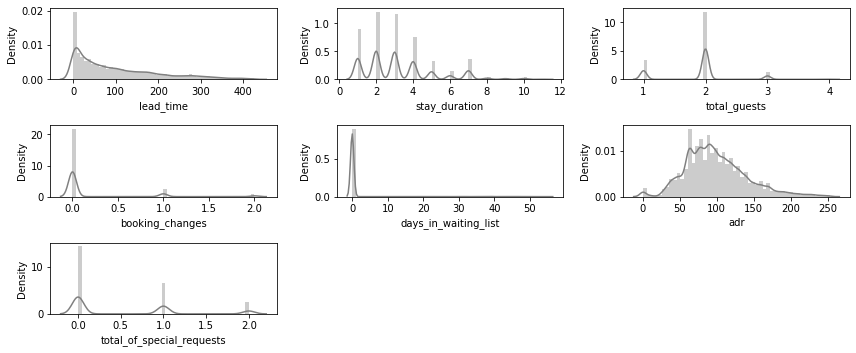

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums1)):
    #plt.subplot(2, len(nums), i+1)
    plt.subplot(3, 3, i+1)
    sns.distplot(df_backup[nums1[i]], color='gray')
    plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


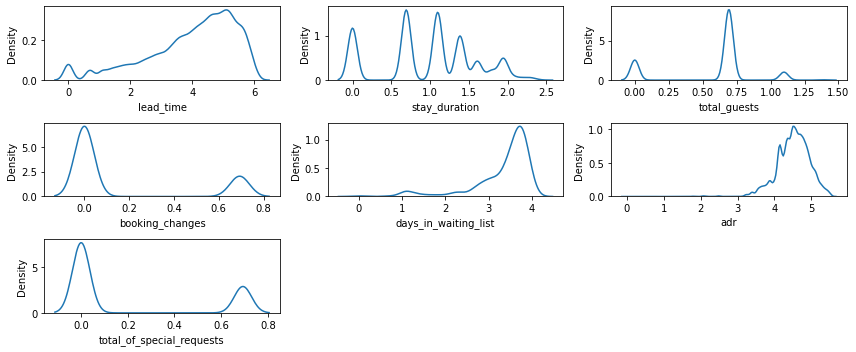

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums1)):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(data = np.log(df_baru[nums1[i]]))
    plt.tight_layout()

In [ ]:
#Scaling
#df_baru['stay_duration'] = StandardScaler().fit_transform(df_baru['stay_duration'].values.reshape(len(df_baru), 1))
#df_baru['total_guests'] = StandardScaler().fit_transform(df_baru['total_guests'].values.reshape(len(df_baru), 1))

In [ ]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97890 entries, 0 to 97889
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           97890 non-null  object 
 1   is_canceled                     97890 non-null  int64  
 2   lead_time                       97890 non-null  int64  
 3   arrival_date_year               97890 non-null  int64  
 4   arrival_date_month              97890 non-null  object 
 5   arrival_date_week_number        97890 non-null  int64  
 6   arrival_date_day_of_month       97890 non-null  int64  
 7   meal                            97890 non-null  object 
 8   country                         97890 non-null  object 
 9   market_segment                  97890 non-null  object 
 10  distribution_channel            97890 non-null  object 
 11  is_repeated_guest               97890 non-null  int64  
 12  previous_cancellations          

##Modelling

In [ ]:
# pemisahan features vs target
#X = df_baru.drop('is_canceled', axis=1)
X = df_baru[nums1].values
y = df_baru['is_canceled'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

##XGboost

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
eval_classification(xg)

Accuracy (Test Set): 0.74
Precision (Test Set): 0.70
Recall (Test Set): 0.61
F1-Score (Test Set): 0.65
roc_auc (test-proba): 0.80
roc_auc (train-proba): 0.80


##XGboost (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

Accuracy (Test Set): 0.80
Precision (Test Set): 0.78
Recall (Test Set): 0.70
F1-Score (Test Set): 0.74
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.99


percobaan 2

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

Accuracy (Test Set): 0.80
Precision (Test Set): 0.78
Recall (Test Set): 0.70
F1-Score (Test Set): 0.74
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.99


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 31.9 MB/s 


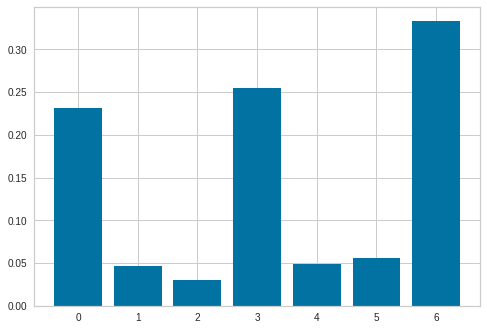

In [ ]:
from matplotlib import pyplot
pyplot.bar(range(len(xg.feature_importances_)), xg.feature_importances_)
pyplot.show()

##Decision Tree

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train, y_train) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.78
Precision (Test Set): 0.72
Recall (Test Set): 0.72
F1-Score (Test Set): 0.72
roc_auc (test-proba): 0.77
roc_auc (train-proba): 1.00


##Decision Tree (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Accuracy (Test Set): 0.78
Precision (Test Set): 0.78
Recall (Test Set): 0.63
F1-Score (Test Set): 0.70
roc_auc (test-proba): 0.82
roc_auc (train-proba): 0.93


In [ ]:
print("s")

s
